In [1]:
!{__import__('sys').executable} -m pip install --quiet --upgrade -r requirements.txt

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
def set_constrained_layout(plt):
    plt.rcParams['figure.constrained_layout.use'] = True
set_constrained_layout(plt)

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def subplots(
    n, 
    ncols = 1, visible = False, 
    *args, **kwargs
):
    fig, axs = plt.subplots(
        *args, **kwargs,
        ncols=ncols, 
        nrows=int(np.ceil(n / ncols))
    )
    for ax in axs.flatten():
        ax.set(visible=visible)
    return fig, axs

In [4]:
session_storage = 'downloads'

import os
os.makedirs(session_storage, exist_ok=True)

In [5]:
import fsspec

fs_dataset = fsspec.filesystem(
    'simplecache', 
    target_protocol='https', 
    cache_storage=session_storage
)

In [6]:
import pandas as pd

import swifter
swifter.set_defaults(
    npartitions=None,
    dask_thres=1,
    scheduler='processes',
    progress_bar=True,
    progress_bar_desc=None,
    allow_dask_on_strings=True,
    force_parallel=True
)


import sklearn as skl
import sklearn.base
import sklearn.compose
#import sklearn.ensemble
import sklearn.feature_extraction
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
import sklearn.svm

import xgboost

import numpy as np

/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [7]:
import sklearnex
#sklearnex.patch_sklearn()

## Dataset

In [8]:
dataset_lyrics = None
with fs_dataset.open('https://github.com/cse158-fa22-team-pushystrokers/datasets/raw/main/dataset-lyrics.csv.gz') as f:
    dataset_lyrics = (
        pd.read_csv(
            f, 
            compression='gzip'
        ).astype({
            'artist': 'category',
            'year': 'datetime64',
            'genre': 'category'
        }, copy=False)
    )

In [9]:
dataset_lyrics

,song,year,artist,genre,lyrics
0,ego-remix,2009-01-01,beyonce-knowles,Pop,"Oh baby, how you doing? You know I'm gonna cut..."
1,then-tell-me,2009-01-01,beyonce-knowles,Pop,"playin' everything so easy, it's like you seem..."
2,honesty,2009-01-01,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...
3,you-are-my-rock,2009-01-01,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I [Verse 1:] If I wrote a..."
4,black-culture,2009-01-01,beyonce-knowles,Pop,"Party the people, the people the party it's po..."
...,...,...,...,...,...
235989,who-am-i-drinking-tonight,2012-01-01,edens-edge,Country,"I gotta say Boy, after only just a couple of d..."
235990,liar,2012-01-01,edens-edge,Country,I helped you find her diamond ring You made me...
235991,last-supper,2012-01-01,edens-edge,Country,Look at the couple in the corner booth Looks a...
235992,christ-alone-live-in-studio,2012-01-01,edens-edge,Country,When I fly off this mortal earth And I'm measu...


## EDA

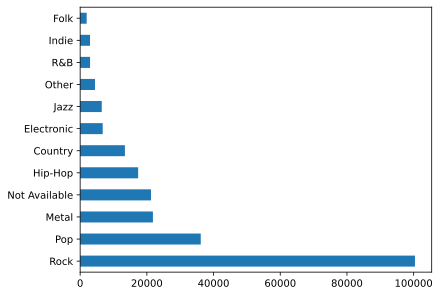

In [10]:
_ = dataset_lyrics['genre'].value_counts().plot(kind='barh')

In [11]:
#dataset_lyrics.drop(dataset_lyrics.index[dataset_lyrics['genre'] == 'Not Available'], inplace=True)

In [12]:
dataset_lyrics = dataset_lyrics[dataset_lyrics['genre'] != 'Not Available']

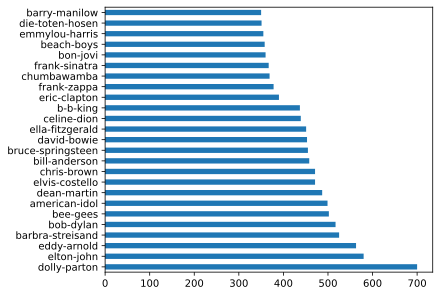

In [13]:
_ = dataset_lyrics['artist'].value_counts().head(25).plot(kind='barh')

In [16]:
import wordcloud
import joblib

def _df_lyrics_generate_wordclouds_per_genre(df):
    df_genre_lyrics = df.groupby('genre', observed=True)['lyrics'].agg(' '.join)
    def _f(lyrics):
        wc = wordcloud.WordCloud(background_color=None, mode='RGBA')
        return wc, wc.generate(lyrics)
    return df_genre_lyrics.swifter.apply(_f)
    
df_wcs = _df_lyrics_generate_wordclouds_per_genre(dataset_lyrics)

fig, axs = subplots(n=len(df_wcs), ncols=3)
for ax, (genre, (wc, im)) in zip(
    axs.flatten(), 
    df_wcs.items()
):
    ax.set(visible=True, title=genre)
    ax.axis('off')
    ax.imshow(im)
fig.show()

KeyboardInterrupt: 

## Predictive Task

## Model

### Baseline Model

In [14]:
def make_dataframe_transformer(cls):
    class cls_(cls):
        def transform(self, *args, **kwargs):
            res = super().transform(*args, **kwargs)
            if isinstance(res, pd.Series):
                return res.to_frame()
            return pd.DataFrame(res)
    return cls_

#### Category Transformer

In [15]:
cat_transformer_baseline = (
    skl.preprocessing.OneHotEncoder(
        handle_unknown='ignore'
    )
)

#### Text Transformer

In [16]:
import joblib

class BaseParallelTransformer(skl.base.TransformerMixin):
    def __init__(self, n_jobs, func, kwargs_func={}):
        super().__init__()
        self.n_jobs = n_jobs
        self.func = func
        self.kwargs_func = kwargs_func

    def fit(self, _X, _y=None):
        return self

    def transform(self, Xs, _y=None):
        return joblib.Parallel(n_jobs=self.n_jobs)(
            joblib.delayed(self.func)(X, **self.kwargs_func) 
                for X in Xs
        )

In [17]:
import nltk
nltk.download('omw-1.4')

class WordTokenizer(BaseParallelTransformer):
    def __init__(self, n_jobs=1, **kwargs):
        super().__init__(
            n_jobs=n_jobs,
            func=nltk.word_tokenize,
            kwargs_func=kwargs
        )

class WordNetLemmatizer(BaseParallelTransformer):
    def __init__(self, n_jobs=1, **kwargs):
        base = nltk.stem.WordNetLemmatizer()
        super().__init__(
            n_jobs=n_jobs,
            func=lambda tokens: list(map(base.lemmatize, tokens)),
            kwargs_func=kwargs
        )

class SnowballStemmer(BaseParallelTransformer):
    def __init__(self, n_jobs=1, **kwargs):
        base = nltk.stem.SnowballStemmer(**kwargs)
        super().__init__(
            n_jobs=n_jobs,
            func=lambda tokens: list(map(base.stem, tokens)),
            kwargs_func={}
        )

[nltk_data] Downloading package omw-1.4 to /home/r8chen/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [18]:
import string

tokens_blocked = (
    set(nltk.corpus.stopwords.words('english'))
        | set(string.punctuation)
)
tokenizer_baseline = skl.pipeline.Pipeline([
    ('filter_cap',
        BaseParallelTransformer(
            n_jobs=-1, 
            func=lambda text: text.lower() 
        )
    ),
    ('tokenizer', WordTokenizer(n_jobs=-1, language='english')),
    ('filter_tokens', 
        BaseParallelTransformer(
            n_jobs=-1, 
            func=lambda tokens: filter(
                lambda token: token not in tokens_blocked,
                tokens
            )
        )
    ),
    ('lemmatizer', WordNetLemmatizer(n_jobs=-1)),
    ('stemmer', SnowballStemmer(n_jobs=-1, language='english'))
])

In [19]:
text_transformer_baseline = skl.pipeline.Pipeline([
    *tokenizer_baseline.steps,
    ('token_count_vec', 
        skl.feature_extraction.text.CountVectorizer(
            tokenizer=lambda x: x,
            preprocessor=None,
            lowercase=False,
            analyzer='word',
            ngram_range=(1, 2)
        )
    ),
    ('token_freq_vec', 
        skl.feature_extraction.text.TfidfTransformer()
    ),
])

#### Pipeline: Model

In [20]:
model_cv_baseline = skl.model_selection.GridSearchCV(
    skl.linear_model.LogisticRegression(
        max_iter=1000
    ),
    param_grid={
        'class_weight': ['balanced'],
        'solver': ['saga'],
        'C': np.logspace(start=-2, stop=-1, num=3),
    }, 
    cv=skl.model_selection.RepeatedStratifiedKFold(n_splits=2, n_repeats=1),
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=3
)

In [21]:
model_cv_gboost = skl.model_selection.GridSearchCV(
    xgboost.XGBClassifier(
        booster='gbtree',
        objective='multi:softmax',
        tree_method='gpu_hist', 
        predictor='gpu_predictor',
        sampling_method='gradient_based',
        enable_categorical=True,
        n_jobs=-1
    ),
    param_grid={
        'learning_rate': [.1, .005],
        'n_estimators': [200],
        'max_depth': [30],
        'subsample': [.75],

        #'gamma': [.1],
        #'reg_alpha': [.1],
        #'reg_lambda': [.1]
    },
    cv=skl.model_selection.RepeatedStratifiedKFold(n_splits=2, n_repeats=1),
    scoring='balanced_accuracy',
    #n_jobs=-1,
    verbose=3
)

####

In [ ]:
predictor_baseline = skl.pipeline.Pipeline([
    ('feature_sel', skl.compose.ColumnTransformer([
        #('cat', cat_transformer_baseline, ['artist']),
        ('text', text_transformer_baseline, 'lyrics')
    ])),#, n_jobs=-1)),
    #('scaler', skl.preprocessing.StandardScaler(with_mean=False)),
    ('classifier_cv', model_cv_baseline)
    #('classifier_cv', model_cv_gboost)
])

df_lyrics = dataset_lyrics.sample(10000)
_ = predictor_baseline.fit(
    #df_lyrics[['artist', 'lyrics']],
    df_lyrics[['lyrics']],
    df_lyrics['genre']
)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END C=0.03162277660168379, class_weight=balanced, solver=saga;, score=nan total time=   3.6s
[CV 2/2] END C=0.03162277660168379, class_weight=balanced, solver=saga;, score=nan total time=   3.3s
[CV 2/2] END C=0.1, class_weight=balanced, solver=saga;, score=nan total time=   3.8s
[CV 1/2] END C=0.1, class_weight=balanced, solver=saga;, score=nan total time=   4.0s
[CV 1/2] END C=0.01, class_weight=balanced, solver=saga;, score=nan total time=   4.4s
[CV 2/2] END C=0.01, class_weight=balanced, solver=saga;, score=nan total time=   4.5s


ValueError: 
All the 6 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/daal4py/sklearn/_device_offload.py", line 88, in wrapper_with_self
    return wrapper_impl(self, *args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/daal4py/sklearn/_device_offload.py", line 74, in wrapper_impl
    result = _run_on_device(func, q, obj, *hostargs, **hostkwargs)
  File "/opt/conda/lib/python3.9/site-packages/daal4py/sklearn/_device_offload.py", line 65, in _run_on_device
    return dispatch_by_obj(obj, func, *args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/daal4py/sklearn/_device_offload.py", line 53, in dispatch_by_obj
    return func(obj, *args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py", line 898, in fit
    clf = super().fit(X, y, sample_weight)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1233, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/conda/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/opt/conda/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/joblib/parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 117, in __call__
    return self.function(*args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/daal4py/sklearn/_device_offload.py", line 88, in wrapper_with_self
    return wrapper_impl(self, *args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/daal4py/sklearn/_device_offload.py", line 74, in wrapper_impl
    result = _run_on_device(func, q, obj, *hostargs, **hostkwargs)
  File "/opt/conda/lib/python3.9/site-packages/daal4py/sklearn/_device_offload.py", line 65, in _run_on_device
    return dispatch_by_obj(obj, func, *args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/daal4py/sklearn/_device_offload.py", line 53, in dispatch_by_obj
    return func(obj, *args, **kwargs)
  File "/opt/conda/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py", line 793, in logistic_regression_path
    return __logistic_regression_path(
  File "/opt/conda/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py", line 669, in __logistic_regression_path
    if n_classes == 2:
UnboundLocalError: local variable 'n_classes' referenced before assignment


In [ ]:
predictor_baseline.named_steps['classifier_cv'].best_params_

{'C': 0.1, 'class_weight': 'balanced', 'solver': 'saga'}

In [ ]:
predictor_baseline.named_steps['classifier_cv'].best_score_

0.24108285114223493

In [22]:
#import tensorflow as tf
#from tensorflow import keras
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1 import keras
tf.disable_eager_execution()
tf.disable_v2_behavior()

2022-11-29 13:30:18.342662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 13:30:19.572280: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/conda/lib/:/opt/conda/lib/
2022-11-29 13:30:19.572481: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/opt/c

Instructions for updating:
non-resource variables are not supported in the long term


In [44]:
#import scikeras as skeras
#import scikeras.wrappers

In [41]:
from keras import backend as K
K.clear_session()

#import tensorflow as tf
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)


df_lyrics = dataset_lyrics.sample(2000)

X_train = text_transformer_baseline.fit_transform(df_lyrics['lyrics'])

le = skl.preprocessing.OneHotEncoder()
y_train = le.fit_transform(df_lyrics[['genre']])


def _f():
    model = keras.Sequential([
        #keras.layers.Embedding(input_dim=X_train.shape[1], output_dim=100),
        #keras.layers.SpatialDropout1D(0.2),
        #keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2),
        #keras.layers.Dense(len(le.categories_), activation='softmax')'
        keras.layers.Dense(1000, activation='relu', input_dim=X_train.shape[1]),
        keras.layers.Dropout(0.75),
        keras.layers.Dense(1000, activation='relu'),
        keras.layers.Dropout(0.75),
        keras.layers.Dense(len(le.categories_[0]), activation='softmax')
    ])
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=keras.optimizers.Adam(learning_rate=0.01), 
        metrics=['accuracy']
    )
    return model
    
clf = _f()#skeras.wrappers.KerasClassifier(_f)
clf_history = clf.fit(
    X_train, y_train, 
    epochs=256, batch_size=64,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=3, 
            min_delta=0.0001
        )
    ]
)

Train on 1800 samples, validate on 200 samples


2022-11-29 13:44:25.486775: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10405 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:89:00.0, compute capability: 6.1
2022-11-29 13:44:25.551417: W tensorflow/c/c_api.cc:291] Operation '{name:'training/Adam/learning_rate/Assign' id:332 op device:{requested: '', assigned: ''} def:{{{node training/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/learning_rate, training/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/256
1800/1800 [==============================] - ETA: 0s - loss: 1.8339 - acc: 0.4356

/opt/conda/lib/python3.9/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2022-11-29 13:44:31.639996: W tensorflow/c/c_api.cc:291] Operation '{name:'loss/mul' id:179 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_2_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


1800/1800 [==============================] - 6s 3ms/sample - loss: 1.8339 - acc: 0.4356 - val_loss: 1.5829 - val_acc: 0.4900
Epoch 2/256
1800/1800 [==============================] - 6s 3ms/sample - loss: 1.2458 - acc: 0.6061 - val_loss: 1.8552 - val_acc: 0.4150
Epoch 3/256
1800/1800 [==============================] - 6s 3ms/sample - loss: 1.0037 - acc: 0.7133 - val_loss: 2.1368 - val_acc: 0.2450
Epoch 4/256
1800/1800 [==============================] - 6s 3ms/sample - loss: 0.9314 - acc: 0.7578 - val_loss: 2.3322 - val_acc: 0.1900


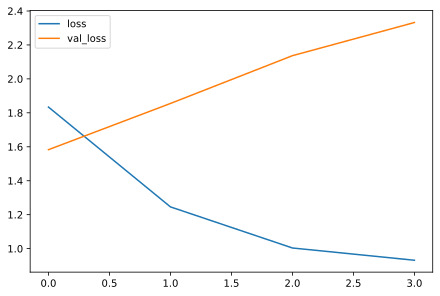

In [42]:
plt.plot(clf_history.history['loss'], label='loss')
plt.plot(clf_history.history['val_loss'], label='val_loss')
plt.legend()


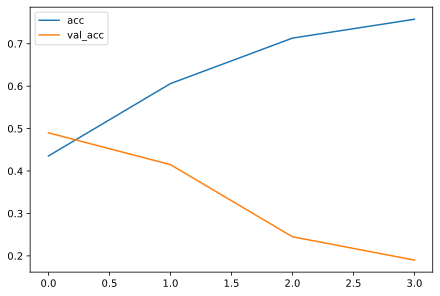

In [43]:
plt.plot(clf_history.history['acc'], label='acc')
plt.plot(clf_history.history['val_acc'], label='val_acc')
plt.legend()
